# Adult census modelization

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

## Load data

In [7]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
                'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv('../../dat/datasets/adult.data', names=column_names)
data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [9]:
df = pd.DataFrame(OrdinalEncoder().fit_transform(data), columns=data.columns)
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,22.0,7.0,2671.0,9.0,12.0,4.0,1.0,1.0,4.0,1.0,25.0,0.0,39.0,39.0,0.0
1,33.0,6.0,2926.0,9.0,12.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,12.0,39.0,0.0
2,21.0,4.0,14086.0,11.0,8.0,0.0,6.0,1.0,4.0,1.0,0.0,0.0,39.0,39.0,0.0
3,36.0,4.0,15336.0,1.0,6.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,39.0,39.0,0.0
4,11.0,4.0,19355.0,9.0,12.0,2.0,10.0,5.0,2.0,0.0,0.0,0.0,39.0,5.0,0.0
5,20.0,4.0,17700.0,12.0,13.0,2.0,4.0,5.0,4.0,0.0,0.0,0.0,39.0,39.0,0.0
6,32.0,4.0,8536.0,6.0,4.0,3.0,8.0,1.0,2.0,0.0,0.0,0.0,15.0,23.0,0.0
7,35.0,6.0,13620.0,11.0,8.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,44.0,39.0,1.0
8,14.0,4.0,1318.0,12.0,13.0,4.0,10.0,1.0,4.0,0.0,105.0,0.0,49.0,39.0,1.0
9,25.0,4.0,8460.0,9.0,12.0,2.0,4.0,0.0,4.0,1.0,79.0,0.0,39.0,39.0,1.0


In [10]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)
trainset, valset = train_test_split(trainset, test_size=0.2, random_state=0)

X_train, y_train = trainset.drop('income', axis=1), trainset.income
X_test, y_test = testset.drop('income', axis=1), testset.income
X_val, y_val = valset.drop('income', axis=1), valset.income

print(f'Training set   : {X_train.shape[0]}')
print(f'Testing set    : {X_test.shape[0]}')
print(f'Validation set : {X_val.shape[0]}')

Training set   : 20838
Testing set    : 6513
Validation set : 5210


## Evaluation function

In [11]:
def evaluation (model, X_train, y_train, X_test, y_test) :
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Print the classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Create and save confusion matrix
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=y_test.unique(), cmap="viridis", colorbar=False)
    plt.grid(False)

    # Create and save learning curve
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, train_sizes=np.linspace(0.1, 1, 10))
    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label='Train score')
    plt.plot(N, val_score.mean(axis=1), label='Val score')
    plt.legend()

    plt.show()

## Decision tree

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      4918
         1.0       0.60      0.62      0.61      1595

    accuracy                           0.81      6513
   macro avg       0.74      0.74      0.74      6513
weighted avg       0.81      0.81      0.81      6513



<Figure size 640x480 with 0 Axes>

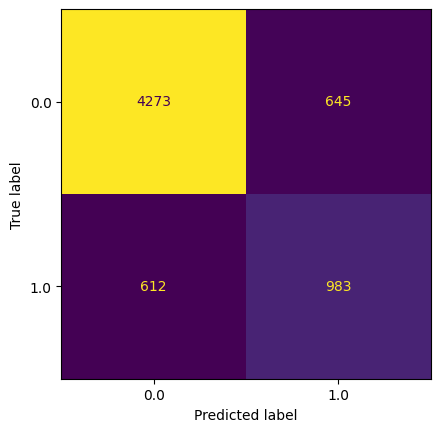

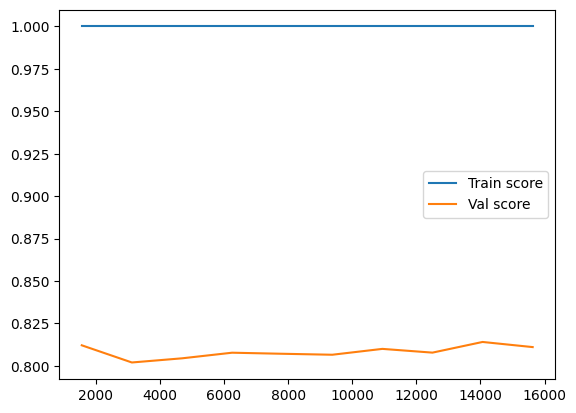

37


In [30]:
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)

evaluation(model, X_train, y_train, X_test, y_test)
print(model.get_depth())

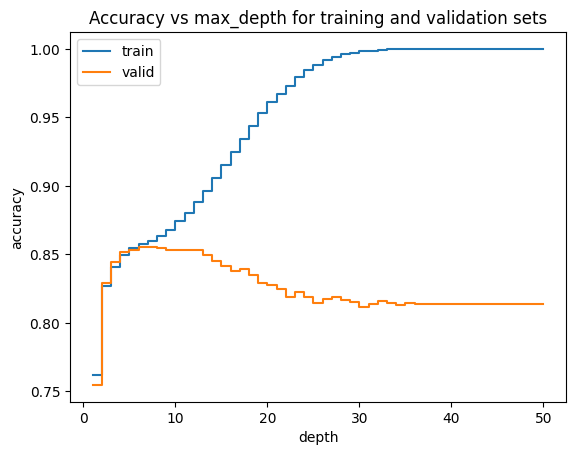

Optimal max_depth: 6


In [19]:
depths = np.linspace(1,50, 50).astype(int)
acc_train=[]
acc_valid=[]

for depth in depths :
  preTree = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=0).fit(X_train, y_train)
  y_pred_train = preTree.predict(X_train)
  y_pred_valid = preTree.predict(X_val)
  acc_train.append(accuracy_score(y_train, y_pred_train))
  acc_valid.append(accuracy_score(y_val, y_pred_valid))

fig, ax = plt.subplots()
ax.set_xlabel("depth")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs max_depth for training and validation sets")
ax.plot(depths, acc_train, label="train", drawstyle="steps-post")
ax.plot(depths, acc_valid, label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

print(f'Optimal max_depth: {depths[np.argmax(acc_valid)]}')

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.91      4918
         1.0       0.79      0.53      0.64      1595

    accuracy                           0.85      6513
   macro avg       0.82      0.74      0.77      6513
weighted avg       0.84      0.85      0.84      6513



<Figure size 640x480 with 0 Axes>

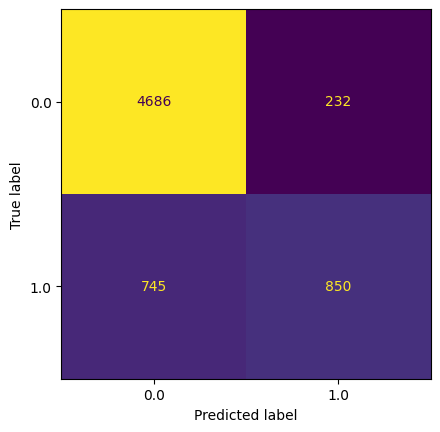

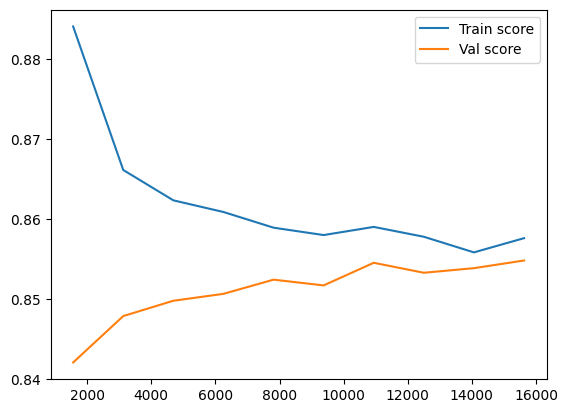

In [22]:
evaluation(DecisionTreeClassifier(random_state=0, max_depth=6, criterion='gini'), X_train, y_train, X_test, y_test)

In [27]:
param_dict = {
    'max_depth': [15, 16, 17, 18, 19, 20 ,21 ,22, 23, 24, 25],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=0, criterion='gini', max_features='sqrt'), param_dict, scoring='accuracy', cv=4)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'max_depth': 20, 'min_samples_leaf': 10}


              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90      4918
         1.0       0.70      0.59      0.64      1595

    accuracy                           0.84      6513
   macro avg       0.79      0.75      0.77      6513
weighted avg       0.83      0.84      0.83      6513



<Figure size 640x480 with 0 Axes>

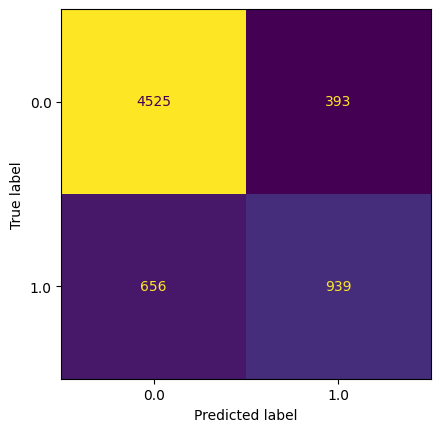

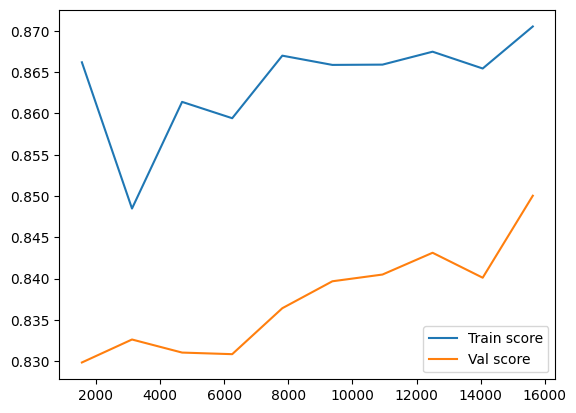

In [28]:
# {'max_depth': 20, 'min_samples_leaf': 10} => 0.84
evaluation(grid.best_estimator_, X_train, y_train, X_test, y_test)

In [32]:
print(f'Old model :' )
print(f'     - depth     : {model.get_depth()}')
print(f'     - leaves    : {model.get_n_leaves()}')
print(f'     - train acc : {accuracy_score(y_train, model.predict(X_train))}')
print(f'     - test acc  : {accuracy_score(y_test, model.predict(X_test))}')
print()
print(f'Optimized model :' )
print(f'     - depth     : {grid.best_estimator_.get_depth()}')
print(f'     - leaves    : {grid.best_estimator_.get_n_leaves()}')
print(f'     - train acc : {accuracy_score(y_train, grid.best_estimator_.predict(X_train))}')
print(f'     - test acc  : {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

Old model :
     - depth     : 37
     - leaves    : 2992
     - train acc : 1.0
     - test acc  : 0.8070013818516812

Optimized model :
     - depth     : 20
     - leaves    : 698
     - train acc : 0.8683174968806987
     - test acc  : 0.8389375095961922


In [35]:
pickle.dump(grid.best_estimator_, open('../../dat/models/dt_opt.sav', 'wb'))

## Random forest

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      4918
         1.0       0.73      0.61      0.67      1595

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.78      6513
weighted avg       0.84      0.85      0.85      6513



<Figure size 640x480 with 0 Axes>

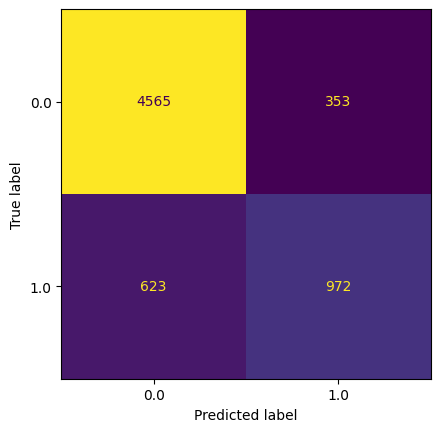

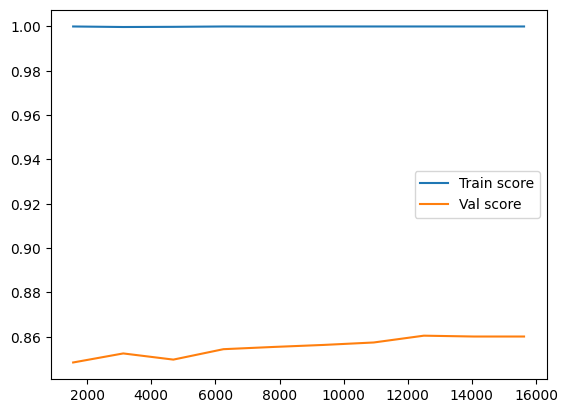

In [42]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)
evaluation(model, X_train, y_train, X_test, y_test)

In [61]:
param_dict = {
    'n_estimators': [185, 186, 187, 188, 189, 190],
    'max_depth': [19, 20, 21, 22]
}

grid = GridSearchCV(RandomForestClassifier(random_state=0, criterion='gini', oob_score=True, min_samples_leaf=2), param_dict, scoring='accuracy', cv=4)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'max_depth': 21, 'n_estimators': 189}


              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      4918
         1.0       0.76      0.61      0.67      1595

    accuracy                           0.86      6513
   macro avg       0.82      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



<Figure size 640x480 with 0 Axes>

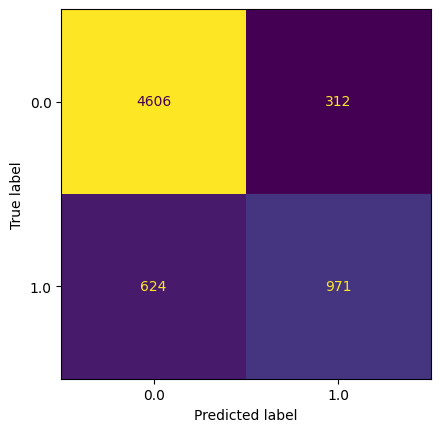

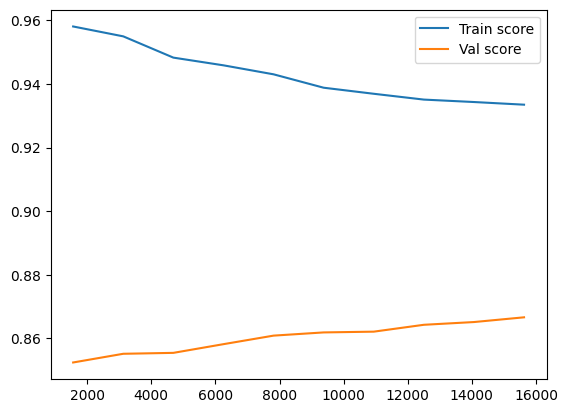

In [62]:
evaluation(grid.best_estimator_, X_train, y_train, X_test, y_test)

In [69]:
print(f'Old model :')
print(f'     - estimators : {model.get_params()["n_estimators"]}')
print(f'     - train acc  : {accuracy_score(y_train, model.predict(X_train))}')
print(f'     - val acc    : {accuracy_score(y_val, model.predict(X_val))}')
print(f'     - test acc   : {accuracy_score(y_test, model.predict(X_test))}')
print()
print(f'Optimized model :' )
print(f'     - estimators : {grid.best_estimator_.get_params()["n_estimators"]}')
print(f'     - train acc  : {accuracy_score(y_train, grid.best_estimator_.predict(X_train))}')
print(f'     - val acc    : {accuracy_score(y_val, grid.best_estimator_.predict(X_val))}')
print(f'     - test acc   : {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

Old model :
     - estimators : 100
     - train acc  : 0.9999040214991842
     - val acc    : 0.8556621880998081
     - test acc   : 0.85014586212191

Optimized model :
     - estimators : 189
     - train acc  : 0.9292158556483348
     - val acc    : 0.8608445297504799
     - test acc   : 0.8562874251497006


In [70]:
pickle.dump(grid.best_estimator_, open('../../dat/models/rf_opt.sav', 'wb'))

## XGBoost

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      4918
         1.0       0.75      0.66      0.70      1595

    accuracy                           0.86      6513
   macro avg       0.82      0.79      0.81      6513
weighted avg       0.86      0.86      0.86      6513



<Figure size 640x480 with 0 Axes>

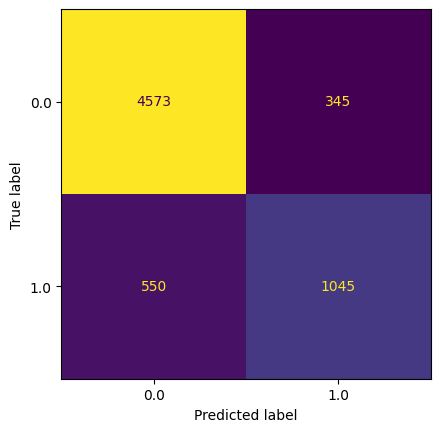

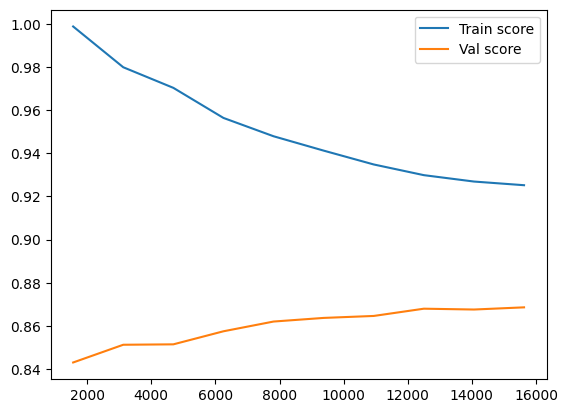

In [7]:
model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
evaluation(model, X_train, y_train, X_test, y_test)

In [23]:
param_dict = {
    'n_estimators': [252, 253, 254, 255],
    'max_depth': [3, 4, 5]
}

grid = GridSearchCV(XGBClassifier(random_state=0, booster='gbtree', max_leaves=1, learning_rate=0.1) , param_dict, scoring='accuracy', cv=4)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'max_depth': 4, 'n_estimators': 254}


              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      4918
         1.0       0.76      0.66      0.71      1595

    accuracy                           0.87      6513
   macro avg       0.83      0.80      0.81      6513
weighted avg       0.86      0.87      0.86      6513



<Figure size 640x480 with 0 Axes>

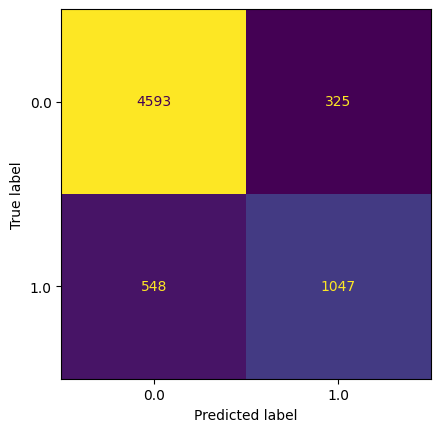

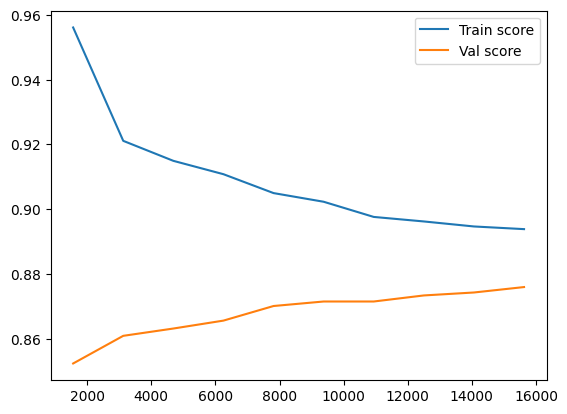

In [24]:
evaluation(grid.best_estimator_, X_train, y_train, X_test, y_test)

In [25]:
pickle.dump(grid.best_estimator_, open('../../dat/models/xgb_opt.sav', 'wb'))

## SVM

D:\cmolinier\Fac\Stages\Stage ESIR2\mutation-testing-ml-fairness\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\cmolinier\Fac\Stages\Stage ESIR2\mutation-testing-ml-fairness\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\cmolinier\Fac\Stages\Stage ESIR2\mutation-testing-ml-fairness\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      4918
         1.0       0.00      0.00      0.00      1595

    accuracy                           0.76      6513
   macro avg       0.38      0.50      0.43      6513
weighted avg       0.57      0.76      0.65      6513



<Figure size 640x480 with 0 Axes>

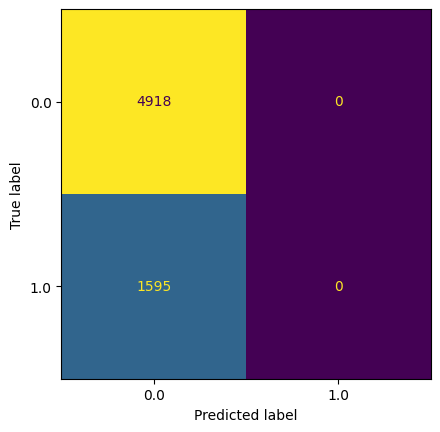

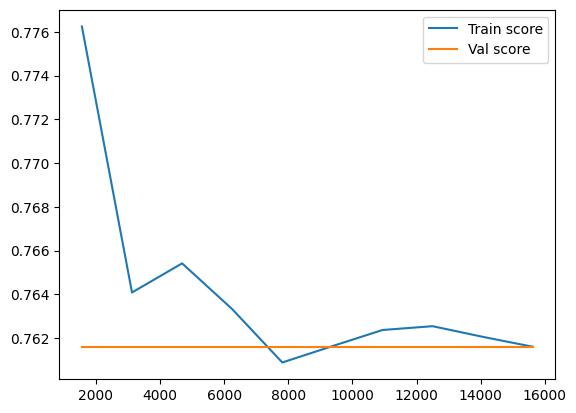

In [27]:
model = SVC(random_state=0)
model.fit(X_train, y_train)
evaluation(model, X_train, y_train, X_test, y_test)

In [ ]:
param_dict = [{'C': [0.1, 1, 10], 'kernel': ['linear']},
              {'C': [0.1, 1, 10], 'kernel': ['rbf', 'sigmoid'], 'gamma': [1, 5]},
              {'C': [0.1, 1, 10], 'kernel': ['poly'], 'degree': [1, 3]}]

grid = GridSearchCV(SVC(random_state=0) , param_dict, scoring='accuracy', cv=4, n_jobs=50)
grid.fit(X_train, y_train)

print(grid.best_params_)